In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:46435 Dashboard: http://127.0.0.1:42706/status,Cluster Workers: 8 Cores: 48 Memory: 118.00 GB


In [2]:
import dask.array as da
import sys
import os
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
#params

plot_dzU_profiles=True


In [4]:
config='EU36'
case='MPC001'
freq='1d'
year='2011'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'


In [5]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [6]:
def dz_var(data,e3,dimdep):
    inv_e3=1/e3
    if dimdep == 'deptht':
        dz_var = (data.shift(deptht=-1) - data)
    if dimdep == 'depthu':
        dz_var = (data.shift(depthu=-1) - data)
    if dimdep == 'depthv':
        dz_var = (data.shift(depthv=-1) - data)
    if dimdep == 'depthw':
        dz_var = (data.shift(depthw=-1) - data)
    return dz_var*inv_e3


In [7]:
filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m01d??.'+str(freq)+'_gridU.nc'))
filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m01d??.'+str(freq)+'_gridV.nc'))
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
u=dsU.vozocrtx
v=dsV.vomecrty
    
    


In [8]:
u

<xarray.DataArray 'vozocrtx' (time_counter: 31, depthu: 75, y: 1718, x: 732)>
dask.array<shape=(31, 75, 1718, 732), dtype=float32, chunksize=(1, 1, 1000, 700)>
Coordinates:
    nav_lat        (y, x) float32 32.741238 32.741158 32.741077 ... -1.0 -1.0
    nav_lon        (y, x) float32 -17.140152 -17.112343 -17.084534 ... -1.0 -1.0
  * depthu         (depthu) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(31,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2011-01-01T12:00:00 ... 2011-01-31T12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_x_velocity
    long_name:           ocean current along i-axis
    units:               m/s
    online_operation:    average
    interval_operation:  180 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 180 s)

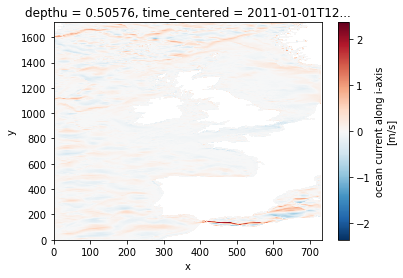

In [9]:
u[0,0].plot()

In [10]:
umean=u.mean(dim='time_counter')

In [11]:
umean

<xarray.DataArray 'vozocrtx' (depthu: 75, y: 1718, x: 732)>
dask.array<shape=(75, 1718, 732), dtype=float32, chunksize=(1, 1000, 700)>
Coordinates:
    nav_lat  (y, x) float32 32.741238 32.741158 32.741077 ... -1.0 -1.0 -1.0
    nav_lon  (y, x) float32 -17.140152 -17.112343 -17.084534 ... -1.0 -1.0 -1.0
  * depthu   (depthu) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
Dimensions without coordinates: y, x

In [12]:
u_anom=u-umean

In [13]:
u_anom

<xarray.DataArray 'vozocrtx' (time_counter: 31, depthu: 75, y: 1718, x: 732)>
dask.array<shape=(31, 75, 1718, 732), dtype=float32, chunksize=(1, 1, 1000, 700)>
Coordinates:
    nav_lat        (y, x) float32 32.741238 32.741158 32.741077 ... -1.0 -1.0
    nav_lon        (y, x) float32 -17.140152 -17.112343 -17.084534 ... -1.0 -1.0
  * depthu         (depthu) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(31,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2011-01-01T12:00:00 ... 2011-01-31T12:00:00
Dimensions without coordinates: y, x

In [14]:
u_anom=u-u.mean(dim='time_counter')
v_anom=v-v.mean(dim='time_counter')
e3u=dsmask.e3u_0
e3v=dsmask.e3v_0


In [15]:
e3u

<xarray.DataArray 'e3u_0' (time_counter: 1, nav_lev: 75, y: 1718, x: 732)>
[94318200 values with dtype=float64]
Coordinates:
  * nav_lev       (nav_lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time_counter  (time_counter) float64 0.0
Dimensions without coordinates: y, x

In [16]:
e3u_d=e3u.rename({'nav_lev':'depthu'})
e3v_d=e3v.rename({'nav_lev':'depthv'})

In [17]:
e3u_d

<xarray.DataArray 'e3u_0' (time_counter: 1, depthu: 75, y: 1718, x: 732)>
[94318200 values with dtype=float64]
Coordinates:
  * depthu        (depthu) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time_counter  (time_counter) float64 0.0
Dimensions without coordinates: y, x

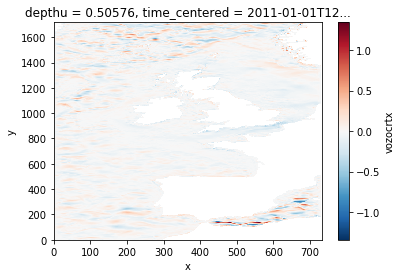

In [18]:
u_anom[0,0].plot()

In [19]:
dz_u = (u_anom.shift(depthu=-1) - u_anom)
dz_v = (v_anom.shift(depthv=-1) - v_anom)

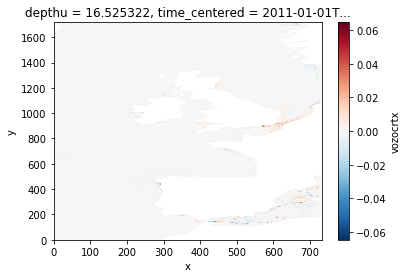

In [20]:
dz_u[0,10].plot()

In [21]:
inv_e3u_d=1/e3u_d
inv_e3v_d=1/e3v_d

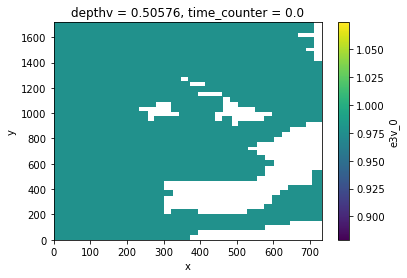

In [22]:
inv_e3v_d[0,0].plot()

In [23]:
import dask.array as da
dask_inv_e3u=da.from_array(inv_e3u_d, chunks=(1, 1, 1000, 700))
dask_inv_e3v=da.from_array(inv_e3v_d, chunks=(1, 1, 1000, 700))


In [24]:
udz=dz_u*dask_inv_e3u
vdz=dz_v*dask_inv_e3v


distributed.nanny - WARNING - Worker process 33499 was killed by signal 11
distributed.nanny - WARNING - Restarting worker


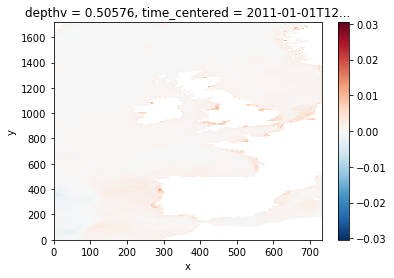

In [25]:
vdz[0,0].plot()

In [26]:
udz2=udz*udz
vdz2=vdz*vdz


In [27]:
udz2_t=udz2.rename({'depthu':'deptht'})
vdz2_t=vdz2.rename({'depthv':'deptht'})

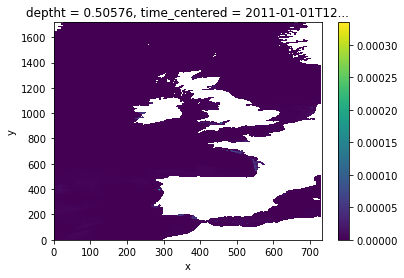

In [28]:
udz2_t[0,0].plot()

In [29]:
shear=udz2_t+vdz2_t

In [30]:
udz2vdz2sum=udz2_t+vdz2_t

distributed.nanny - WARNING - Worker process 33509 was killed by signal 6
distributed.nanny - WARNING - Restarting worker


distributed.nanny - WARNING - Worker process 33513 was killed by signal 6
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 34564 was killed by signal 11
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 33503 was killed by signal 11
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 34473 was killed by signal 11
distributed.nanny - WARNING - Restarting worker


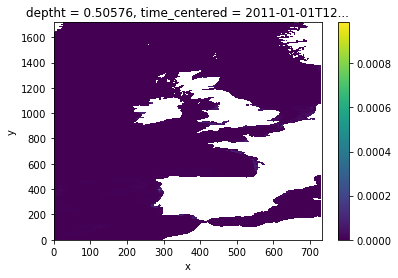

In [31]:
udz2vdz2sum[0,0].plot()

In [32]:
shear=np.sqrt(udz2vdz2sum)

In [33]:
shear

<xarray.DataArray (time_counter: 31, deptht: 75, y: 1718, x: 732)>
dask.array<shape=(31, 75, 1718, 732), dtype=float64, chunksize=(1, 1, 1000, 700)>
Coordinates:
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(31,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2011-01-01T12:00:00 ... 2011-01-31T12:00:00
Dimensions without coordinates: y, x

In [34]:
shear.mean(dim='x').mean(dim='y').plot()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:41244 remote=tcp://127.0.0.1:46435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:41246 remote=tcp://127.0.0.1:46435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:41248 remote=tcp://127.0.0.1:46435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:41258 remote=tcp://127.0.0.1:46435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:41260 remote=tcp://127.0.0.1:46435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:41262 remote=tcp://127.0.0.1:46435>
distributed.nanny - WARNING - Worker process 33501 was killed by signal 11
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 33507 was killed by signal 6
distributed.nanny - WARNING - Restarting worker
distributed

KilledWorker: ("('open_dataset-concatenate-9cefb6de787355d17a9587323208cf11', 0, 0, 0, 0)", <Worker 'tcp://127.0.0.1:40576', memory: 0, processing: 2754>)

In [ ]:
shear[0,0].plot()